## Guess the Genre!
k-nn Classification of Spotify songs based on their numerical statistics.

## Introduction

The exact definition of each music genre is sometimes difficult to express, and people tend to classify songs based on 'feel' and loose characteristics. This project's goal is to predict a song's genre based on concrete numerical characteristics. We are using an open-source dataset on Kaggle (that has been constructed using Spotify API) which contains information on various tracks' numerical and identification characteristics such as `instance_id`, `artist_name`, `track_name`, `popularity`, `acousticness`, `danceability`, `duration_ms`, `energy`, `instrumentalness`, `key`, `liveness`, `loudness`, `mode`, `speechiness`, `tempo`, `obtained_date`, `valence`, and `music_genre`. The dataset was last updated in December of 2021 but the track's obtained data (from the server) is from April 2021.

Question: How is a song classified into a genre based on its numerical characteristics?

### Methods & Results

In [43]:
install.packages("corrplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [44]:
### Loading Libraries into R
### Run this cell before continuing.
library(tidymodels)
library(tidyverse)
library(repr)
library(cowplot)
library(GGally)
library(caret)
library(stats)
library(corrplot)
options(repr.matrix.max.rows = 6)

**1. Loading the Data** </br>
The data, originally sourced from Kaggle, is loaded in from an online source.

In [45]:
set.seed(200)
raw_data <- read_csv("https://raw.githubusercontent.com/Lollipop-27/DCSI100-Project/main/data/music_genre.csv")
raw_data

Parsed with column specification:
cols(
  instance_id = col_double(),
  artist_name = col_character(),
  track_name = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_character(),
  obtained_date = col_character(),
  valence = col_double(),
  music_genre = col_character()
)



instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
32894,Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1,0.941,0.7920,A#,0.115,-5.201,Minor,0.0748,100.889,04-Apr,0.759,Electronic
46652,Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.9500,D,0.124,-7.043,Minor,0.0300,115.002,04-Apr,0.531,Electronic
30097,Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.0118,G#,0.534,-4.617,Major,0.0345,127.994,04-Apr,0.333,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
39767,Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0,D,0.143,-5.443,Major,0.1460,131.079,04-Apr,0.395,Hip-Hop
57944,The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773,0.472,0,G,0.106,-5.016,Minor,0.0441,75.886,04-Apr,0.354,Hip-Hop
63470,Naughty By Nature,Hip Hop Hooray,67,0.10200,0.862,267267,0.642,0,F#,0.272,-13.652,Minor,0.1010,99.201,04-Apr,0.765,Hip-Hop


**2. Wrangling & Cleaning the Data** </br>
The data has a few rows with missing N/A values. We remove them using na.omit(). Unfortunately, in the tempo column, N/A values are shown using "?" so we filter them separately. The raw data set we selected has about 50,000 rows, whose excessive size is a serious limitation on performance and causes minute-long load times. For sake of reasonable computation time and after discussion with the teaching assistant, we chose to use group_by() and slice_sample() to randomly select 1000 rows from each of the 10 genres, for a total of 10,000 rows. We chose the number of 10,000 based on our computers' strength to have a reasonably fast program.

We filtered N/A values before slicing so that we have an exact equal number of tracks in each genre and to ensure that every predictor has equal representation in the training data.

In [46]:
set.seed(1234)

data <- raw_data %>%
            na.omit() %>%
            filter(tempo != "?") %>%
            group_by(music_genre) %>%
            slice_sample(n=1000) %>%
            ungroup()
data

instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
33762,for KING & COUNTRY,joy.,61,0.0102,0.680,233947,0.536,0.00105,F,0.113,-6.669,Minor,0.0582,119.958,04-Apr,0.417,Alternative
32719,BANKS,Godless,60,0.0242,0.385,190067,0.692,0.00000,A,0.110,-4.843,Minor,0.1580,155.794,04-Apr,0.300,Alternative
53581,MARINA,Handmade Heaven,55,0.3670,0.379,209891,0.503,0.00000,F#,0.111,-5.814,Minor,0.0374,106.999,04-Apr,0.284,Alternative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
38007,Gin Blossoms,Til I Hear It From You,62,0.0812,0.560,230800,0.798,1.54e-06,A,0.327,-6.672,Major,0.0316,124.397,04-Apr,0.675,Rock
23380,Dirty Heads,Garland,51,0.6480,0.741,229782,0.521,8.94e-06,E,0.111,-8.725,Minor,0.0363,87.003,04-Apr,0.783,Rock
56803,Rebelution,Settle Down Easy,57,0.1300,0.731,236976,0.718,4.11e-06,F,0.188,-6.177,Major,0.0573,77.51,04-Apr,0.850,Rock


Some columns are unusable for predicting genre because kknn classification requires numerical predictors. We used select() to remove all character columns excluding the music_genre column, which we used mutate() to turn into factors.

A usable column with numerical values, tempo, is incorrectly stored as a character column. We use mutate() to turn it into a double.

Obtained dates were formatted in a strange way so we used mutate() to change it to yyyy-mm-dd format.

In [47]:
#cleaning the vectors type and n/a genres
data <- data%>%
  mutate (music_genre = as_factor(music_genre)) %>%
  mutate(tempo = as.double(tempo)) %>%
  mutate(key = as_factor(key)) %>%
  mutate(mode = as_factor (mode)) %>%
  select(-instance_id, -artist_name, -track_name, -key, -mode)

#cleaning the date column
data <- mutate(data,
              obtained_date = 
                as.Date(paste(data$obtained_date, "-21",sep = ""), 
                        "%d-%b-%y"))
data

popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,obtained_date,valence,music_genre
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<fct>
61,0.0102,0.680,233947,0.536,0.00105,0.113,-6.669,0.0582,119.958,2021-04-04,0.417,Alternative
60,0.0242,0.385,190067,0.692,0.00000,0.110,-4.843,0.1580,155.794,2021-04-04,0.300,Alternative
55,0.3670,0.379,209891,0.503,0.00000,0.111,-5.814,0.0374,106.999,2021-04-04,0.284,Alternative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,0.0812,0.560,230800,0.798,1.54e-06,0.327,-6.672,0.0316,124.397,2021-04-04,0.675,Rock
51,0.6480,0.741,229782,0.521,8.94e-06,0.111,-8.725,0.0363,87.003,2021-04-04,0.783,Rock
57,0.1300,0.731,236976,0.718,4.11e-06,0.188,-6.177,0.0573,77.510,2021-04-04,0.850,Rock


**3. Exploratory Analysis** 

We wanted to have a more clear display of which predictors we should use. First, we took the mean of each variable for each genre. We then made a plot on the different audio features distribution in different music genres.

`summarise()` ungrouping output (override with `.groups` argument)



Rows: 10
Columns: 12
$ music_genre          <fct> Alternative, Anime, Blues, Classical, Country, E…
$ avg_popularity       <dbl> 50.151, 24.077, 35.149, 29.370, 45.993, 37.898, …
$ avg_acousticness     <dbl> 0.1638933, 0.2841309, 0.3130045, 0.8666177, 0.27…
$ avg_danceability     <dbl> 0.5426070, 0.4747827, 0.5302540, 0.3078130, 0.57…
$ avg_duration_ms      <dbl> 209221.9, 208907.2, 223672.5, 288044.4, 199670.9…
$ avg_energy           <dbl> 0.7091347, 0.6611658, 0.6087183, 0.1796353, 0.62…
$ avg_instrumentalness <dbl> 0.060569524, 0.281104798, 0.082412223, 0.5903997…
$ avg_liveness         <dbl> 0.1951513, 0.1891593, 0.2244830, 0.1530543, 0.18…
$ avg_loudness         <dbl> -6.571777, -8.013425, -9.002533, -21.419306, -7.…
$ avg_speechiness      <dbl> 0.0863302, 0.0629816, 0.0626791, 0.0487301, 0.04…
$ avg_tempo            <dbl> 120.5042, 127.4977, 121.6757, 103.7299, 123.9182…
$ avg_valence          <dbl> 0.4451543, 0.4274723, 0.5775599, 0.2121462, 0.53…


music_genre,avg_popularity,avg_acousticness,avg_danceability,avg_duration_ms,avg_energy,avg_instrumentalness,avg_liveness,avg_loudness,avg_speechiness,avg_tempo,avg_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alternative,50.151,0.1638933,0.5426070,209221.9,0.7091347,0.06056952,0.1951513,-6.571777,0.0863302,120.5042,0.4451543
Anime,24.077,0.2841309,0.4747827,208907.2,0.6611658,0.28110480,0.1891593,-8.013425,0.0629816,127.4977,0.4274723
Blues,35.149,0.3130045,0.5302540,223672.5,0.6087183,0.08241222,0.2244830,-9.002533,0.0626791,121.6757,0.5775599
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Jazz,40.543,0.5095509,0.588205,247030.0,0.4754309,0.36124639,0.1729452,-11.122302,0.0723890,111.7762,0.5207171
Rap,60.459,0.1763840,0.699809,196330.0,0.6467970,0.01164208,0.2057147,-6.759269,0.1868070,121.4787,0.4440734
Rock,59.558,0.1910341,0.539960,214556.5,0.6875809,0.06199448,0.1789082,-7.281840,0.0541505,123.4267,0.5197208


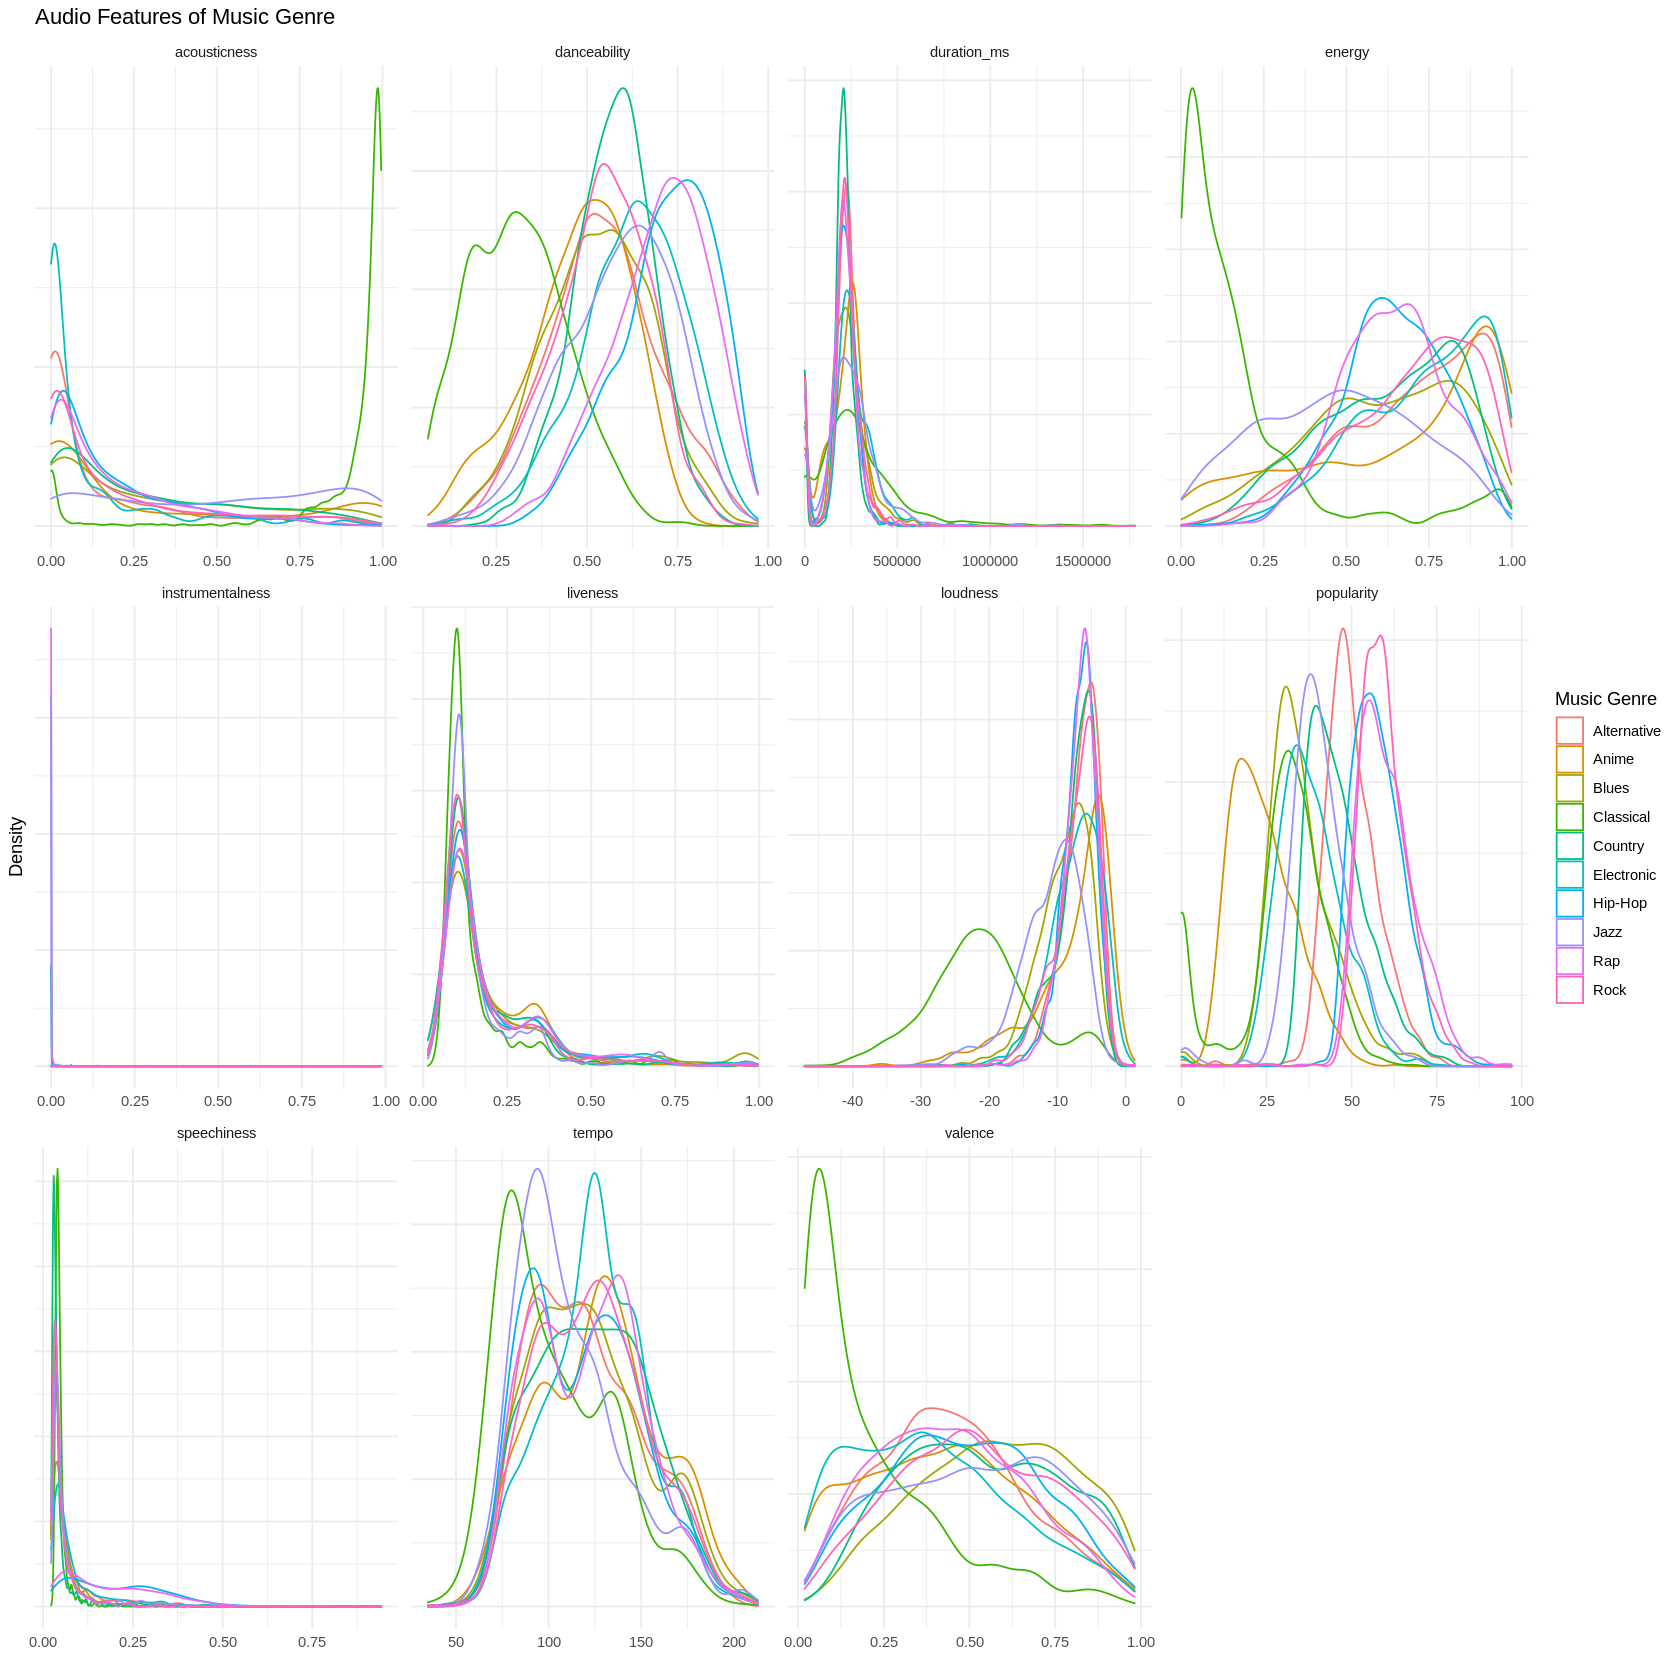

In [48]:
#dataframe of mean of each variable for each genre
general_distribution <- data %>%
  group_by(music_genre) %>%
  summarise(avg_popularity = mean(popularity),
            avg_acousticness = mean(acousticness),
            avg_danceability = mean(danceability),
            avg_duration_ms = mean(duration_ms),
            avg_energy = mean(energy),
            avg_instrumentalness = mean(instrumentalness),
            avg_liveness = mean(liveness),
            avg_loudness = mean(loudness),
            avg_speechiness = mean(speechiness),
            avg_tempo = mean(tempo),
            avg_valence = mean(valence)) %>%
  glimpse()
general_distribution

options(repr.plot.width = 14, repr.plot.height =14)
data %>% 
  select(-obtained_date) %>% 
  pivot_longer(1:11) %>% 
  ggplot(aes(x = value)) + 
  geom_density(aes(color = music_genre)) +
  facet_wrap(~name, ncol =4, scales="free") +
  labs(title = "Audio Features of Music Genre", x = "", y = "Density", color="Music Genre") +
  theme_minimal() + theme(axis.text.y = element_blank())

_Figure 1.1: The numerical features of each music genre_

From this plot, we understood that variables like acousticness can help us a lot to distinguish a genre like "Classical" from other genres. On the other hand, it seems that a variable like "duration_ms" may not be that useful because all of the genres have approximately the same distribution of duration. Now if we look at a variable like "popularity", we can observe that genre distributions are scattered over different ranges and it looks like it can be a helpful predictor for our model.

We used the algorithm for the forward selection in the sketch of our project, but due to numerous variables and a large dataset, it took a very long time to run. So we used another method from the "Caret" library that will give us the 6 most important variables in our dataset.

Also, we used a sample of n=20 from each group to plot so we can see the relationship between 2 variables (that we saw in previous parts) in different genres.

rpart variable importance

                 Overall
loudness          100.00
acousticness       90.21
energy             89.59
popularity         86.00
instrumentalness   31.73
danceability       25.51
valence             0.00
duration_ms         0.00
liveness            0.00
speechiness         0.00
tempo               0.00

Adding missing grouping variables: `music_genre`



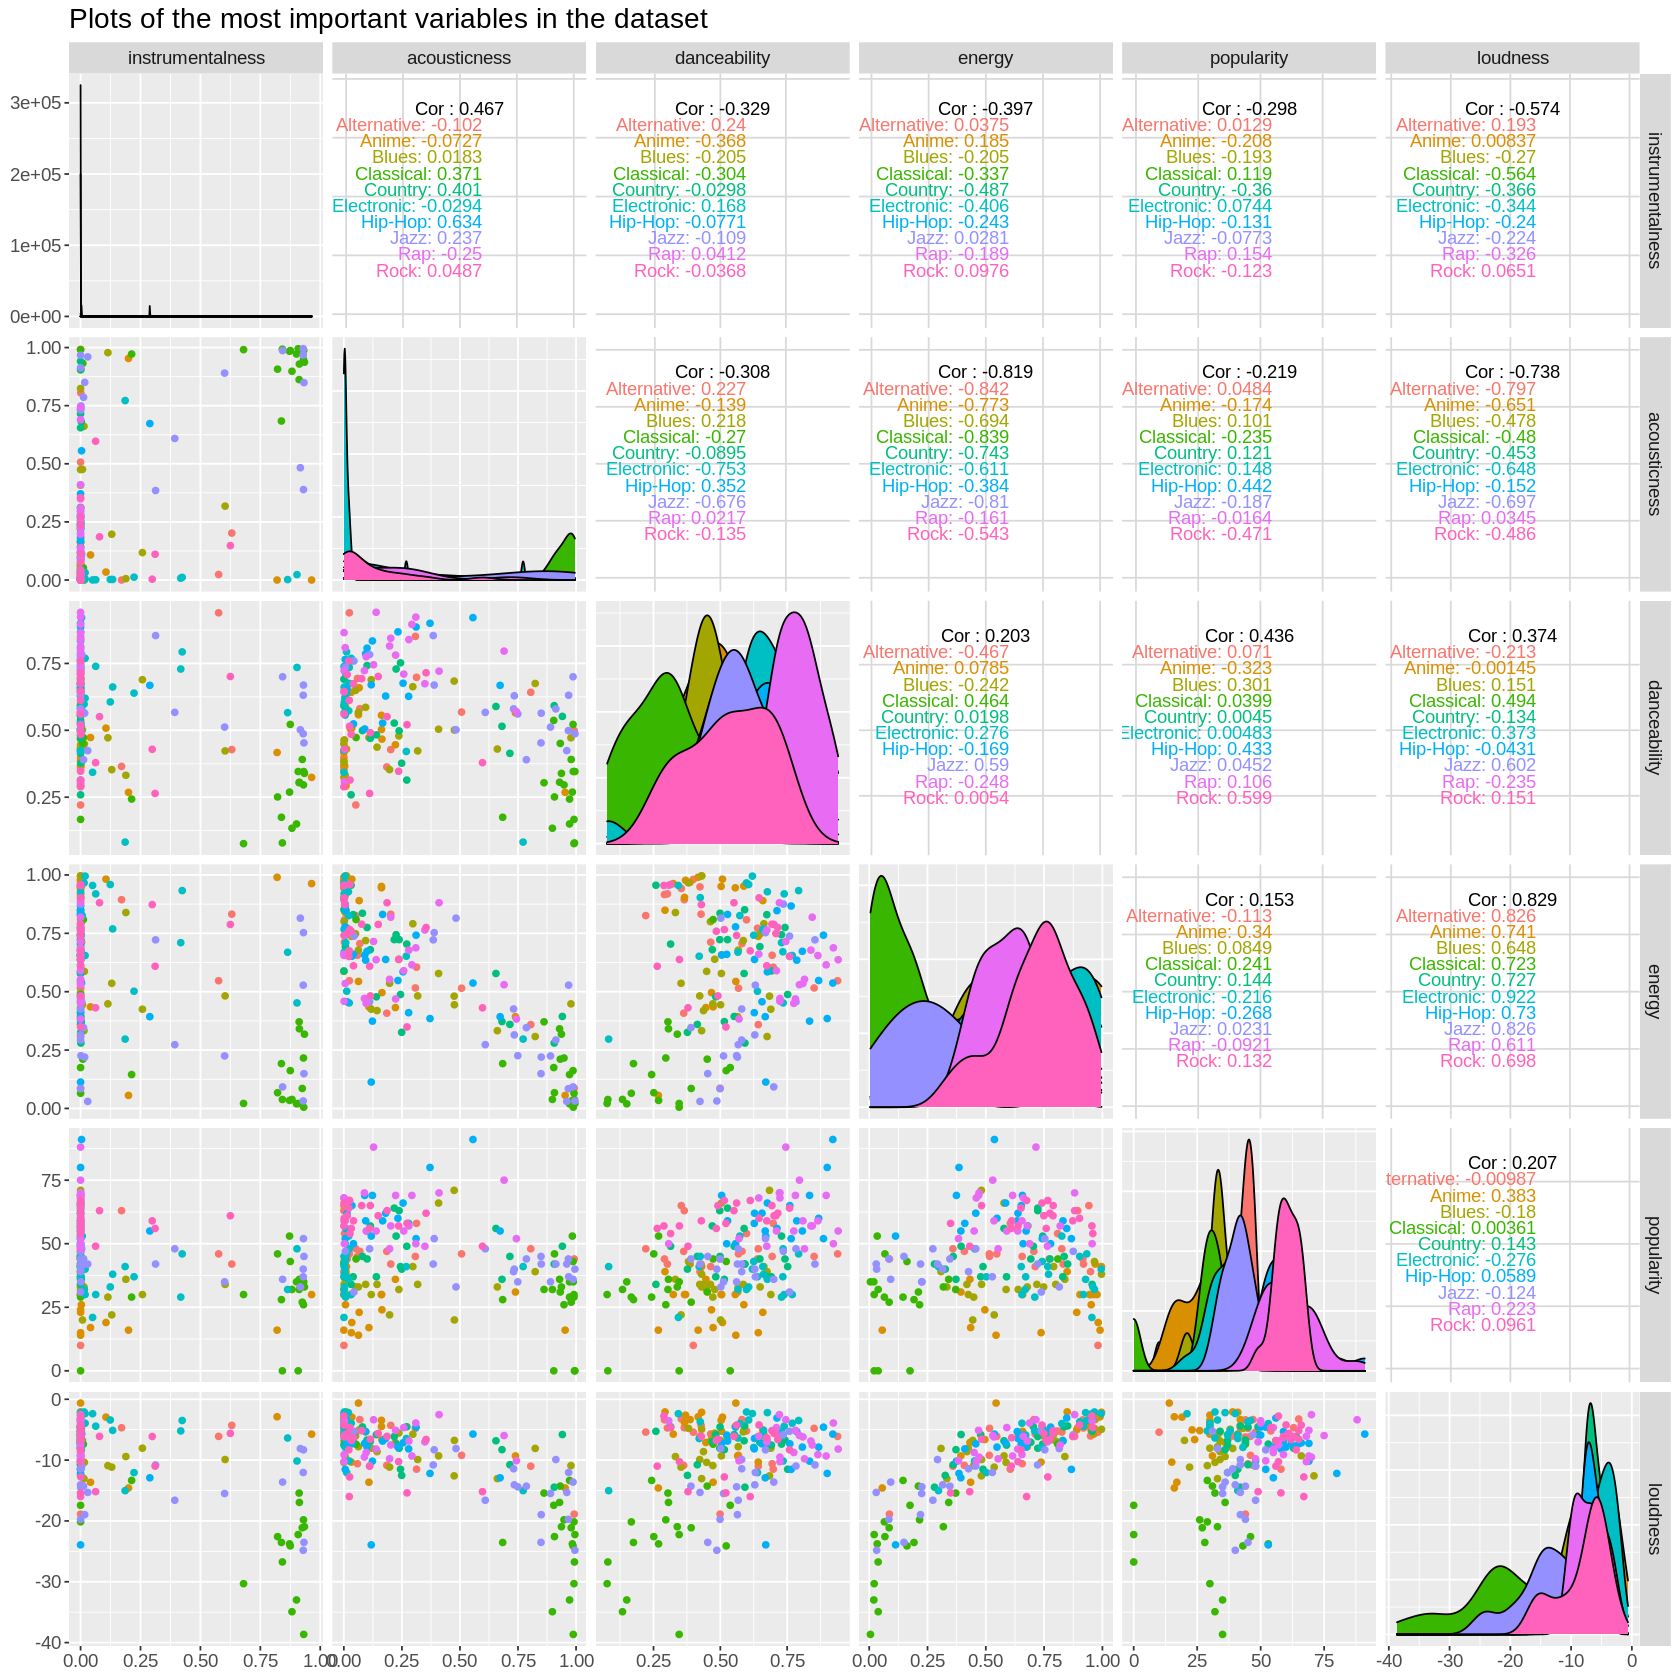

In [49]:
#finding the most important variables to distinguish music genre
rrfMod <- train(music_genre ~ popularity+acousticness + danceability + duration_ms+
                  energy + instrumentalness + liveness + loudness +
                  speechiness +tempo +valence , data=data, method="rpart")
rrfImp <- varImp(rrfMod)
rrfImp

#use a sample of n=20 from each group to plot
set.seed(100)
samples <- data %>%
  group_by(music_genre) %>%
  slice_sample(n=20) %>%
  select(instrumentalness, acousticness,danceability,energy,popularity, loudness)

#plots of each 2 variables from rrfImp
options(repr.plot.height = 20, repr.plot.width = 14, repr.plot.height = 14)
variables_plot <- ggpairs(samples, columns = 2:7, ggplot2::aes(colour = music_genre)) +
  ggtitle("Plots of the most important variables in the dataset") +
  theme(text = element_text(size =14))
variables_plot


_Figure 1.2: Plotting the most influential variables from the dataset_

**4. Data Analysis** </br>
We first split the data into our training and testing sets.

We chose to split at 75:25 to provide a good balance between making a good model and being able to evaluate its accuracy properly. A 75% split was also a good number to ensure reasonable training time, given how much data our dataset contains.

In [50]:
data_split <- initial_split(data, prop = 0.75, strata = music_genre)
 data_training <- training(data_split)
 data_testing <- testing(data_split)

For the data recipe, we choose to use popularity, acousticness, danceability, acousticness, energy, instrumentalness, loudness, speechiness,tempo and valence as our predictors to predict the music genre.

We perform five fold cross-validation on our data with the data_recipe and data_spec we created earlier and try 20 different k values. We used collect_metrics() to aggregate the mean and standard error for each k value and plot it on a line plot to visualize the accuracies and identify the best neighbor count.

In [51]:
# Set the seed
set.seed(1234) 

# Create the model
genre_recipe <- recipe(music_genre ~ popularity + danceability + acousticness +
                        energy + instrumentalness +loudness + speechiness+
                       tempo + valence,
                      data = data_training) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

genre_vfold <- vfold_cv(data_training, v = 5, strata = music_genre)

genre_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

genre_results <- workflow() %>%
      add_recipe(genre_recipe) %>%
      add_model(genre_tune) %>%
      tune_grid(resamples = genre_vfold, grid = 20) %>%
      collect_metrics()

accuracies <- genre_results %>%
      filter(.metric == "accuracy")



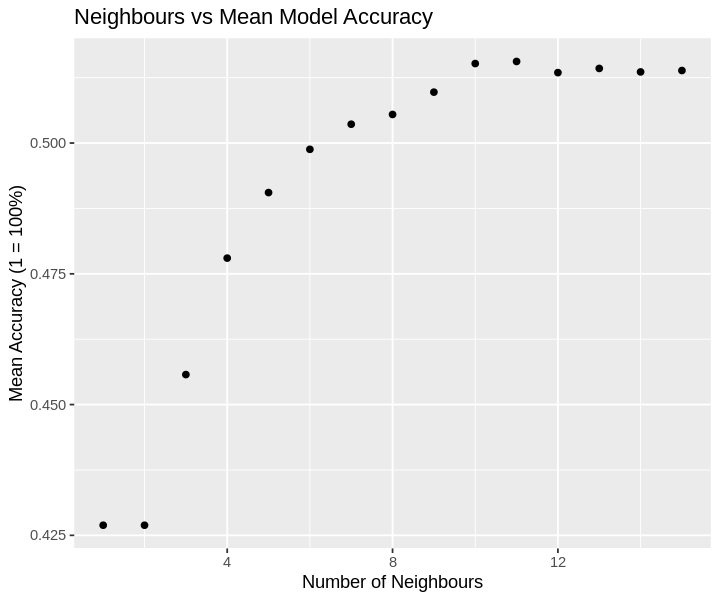

In [52]:
# Display the k value accuracies
options(repr.plot.height = 5, repr.plot.width = 6)

cross_val_plot <- ggplot(accuracies, aes(x= neighbors, y = mean)) +
                geom_point() +
                ggtitle("Neighbours vs Mean Model Accuracy") +
                labs(x="Number of Neighbours", y="Mean Accuracy (1 = 100%)")

cross_val_plot

_Figure 1.3: Accuracy for different k values_

Accuracy is highest at k=11, so we recreate our workflow using k=11.

In [53]:
# Set the seed. 
set.seed(9999) 

# Build model with k=11
genre_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
       set_engine("kknn") %>%
       set_mode("classification")

genre_fit <- workflow() %>%
       add_recipe(genre_recipe) %>%
       add_model(genre_spec) %>%
       fit(data = data_training)

We used our final model to make predictions on the test data set, and used the bind_cols function to join the prediction column to the original test data. We then report the accuracy of this prediction using the metrics function. We also report the confusion matrix using the conf_mat function.

In [54]:
data_predictions <- predict(genre_fit , data_testing) %>%
      bind_cols(data_testing)

data_metrics <- data_predictions %>%
       metrics(truth = music_genre, estimate = .pred_class)

data_conf_mat<- data_predictions %>%
       conf_mat(truth = music_genre, estimate = .pred_class)

data_metrics
data_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5108000
kap,multiclass,0.4564444


             Truth
Prediction    Alternative Anime Blues Classical Country Electronic Hip-Hop Jazz
  Alternative          80     9    18         7      34         16       8   13
  Anime                 3   155    25         9       5         18       0    5
  Blues                 7    19   110         8      19         11       0   18
  Classical             2    21     5       206       1          2       0   21
  Country              43    19    38         5     126         24       3   30
  Electronic            8    14     8         2       7        122       1   33
  Hip-Hop              24     0     2         0       6         14     115    9
  Jazz                 13    12    32        12      11         30       4  108
  Rap                  17     0     0         0       8          8      99    4
  Rock                 53     1    12         1      33          5      20    9
             Truth
Prediction    Rap Rock
  Alternative  10   24
  Anime         0    1
  Blues      

### Discussion

The focus of our project was to answer the question: How is a song classified into a genre based on its numerical characteristics?

Looking at the confusion matrix gives us an idea of the numerical similarity between genres. It seems Anime, Classical, Country, Electronic, Jazz, and Rock are predicted with good accuracy, but Alternative, Hip-Hop, and Rap are easily confused with one or a few other genres. This suggests that the genres that are more easily confused are less concretely defined, or that are very similar to another genrse, and that the genres that are predicted correctly are unique. For instance, Hip-hop is frequently mispredicted as Rap and Rap is frequently confused for Hip-hop, suggesting that the two genres are statistically similar. Classical, on the other hand, is almost never confused for anything else, which suggests that it is a unique genre.

The confusion results are expected; classical music is distinguished from most other genres by its time and origin, dating back hundreds of years and originating out of Europe. As a result, its aural and numerical characteristics are also distinguished from other genres, being uniquely calm and instrumental, for instance. Hip-hop and rap, on the other hand, both originate from North America and were developed around the same 1970s era in similar cultural groups. This caused the development of similar styles, and thus common numerical characteristics such as high energy, high speechiness, etc.

Our model is 51% accurate, which is a reasonable number given the vague borders that separate song genres. In an application as low-stakes as predicting music genre, the model's accuracy is less important, compared to other models that may take on tasks such as in financial service applications. It may even be argued that the _true_ accuracy of the model is higher, since some songs _are_ in fact an intersection between multiple genres. The original dataset's genre column (which was used as the "correct" genre when assessing prediction accuracy) may not be right in assigning a single "true" genre, when songs may belong to multiple. In some applications, the model's variability in predicting a song's genre may even be useful, such as when a company uses the model to place a song into one of its genre playlists: a track may belong on multiple playlists.

There are real-life applications to these findings. The ability to correlate numerical characteristics to a genre may be used by Spotify, for example, when an artist uploads a new song to the database. Identifying the genre of new audio files would allow a company like Spotify to collect statistics on their song database; finding the proportion of genres in the database may reveal weak spots in the diversity of songs available, and prompt action to onboard more, say, R&B artists. Genre classification would also allow the company to place new songs into a genre-based suggestion playlist, for example, or help identify similar songs to recommend to users. The model's independence from human input is also helpful in reducing human work required, avoiding malicious human error (Ex. Maybe a rapper thinks it's funny to label his new rap beat a country song), and maybe even improving accuracy since the model relies on objective numerical variables instead of 'feel' to assign a genre.

A further investigation of this project may involve analysis of the lyrical characteristics of each genre, using a lyrical transcription. This would allow us to identify frequent words or phrases in various genres, which opens up the possibility of identifying _sentiment_ and linguistical property variations across genres. How does the frequency of slang vary across genres? Which time era is the language of each genre most representative of? How does language variation impact genre?

## References

There are many studies showing that music has its own distinct fields and genres. Music is primarily classified into "four distinct genre types-Avant-garde, Scene-based, Industry-based, and Traditionalist." (" Classification as Culture: Types and Trajectories of Music Genres - ProQuest," 2022). Similarly, there have been attempts in the academic field to use computers to retrieve information about their music, and thus to use "music genre recognition (MGR)" to assess musical genres. However, the data shows that it is difficult to recognize genre in musical signals by "classification accuracy, recall, and precision, confusion tables, necessarily reflecting the capacity of a system to recognize genre in musical signals" (Sturm, 2013).

How do new music genres emerge? Diversification processes in symbolic knowledge bases. (2019). Retrieved March 11, 2022, from Regional Studies website: https://www.tandfonline.com/doi/full/10.1080/00343404.2019.1580817
    
Innovation in Creative Industries: Does (Related) Variety Matter for the Creativity of Urban Music Scenes? (2019). Retrieved March 11, 2022, from Economic Geography website: https://www.tandfonline.com/doi/full/10.1080/00130095.2018.1549944?src=recsys

Lena, J. C., & Peterson, R. A. (2008). Classification as Culture: Types and Trajectories of Music Genres. American Sociological Review, 73(5), 697–718. https://doi.org/10.1177/000312240807300501

Sturm, B. L. (2013). Classification accuracy is not enough. Journal of Intelligent Information Systems, 41(3), 371–406. https://doi.org/10.1007/s10844-013-0250-y

Vergnou, B. (2021, August). Spotify Recommendation. Kaggle. Retrieved March 2022, from https://www.kaggle.com/datasets/bricevergnou/spotify-recommendation 